In [1]:
import os
import shutil
import random
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import itertools

2024-06-20 18:53:24.058959: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 18:53:24.072710: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-20 18:53:24.254457: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-20 18:53:27.446989: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Define paths
original_data_dir = 'Data'
split_data_dir = 'NewCassavaData_Split'
train_data_dir = os.path.join(split_data_dir, 'train')
val_data_dir = os.path.join(split_data_dir, 'val')
test_data_dir = os.path.join(split_data_dir, 'test')

In [4]:
# Create directories if they don't exist
os.makedirs(train_data_dir, exist_ok=True)
os.makedirs(val_data_dir, exist_ok=True)
os.makedirs(test_data_dir, exist_ok=True)

In [5]:
# # Function to split dataset
# def split_dataset(source, train, val, test, split_ratio=(0.8, 0.1, 0.1)):
#     classes = os.listdir(source)

#     for class_name in classes:
#         class_dir = os.path.join(source, class_name)
#         files = os.listdir(class_dir)
#         num_files = len(files)
#         num_train = int(num_files * split_ratio[0])
#         num_val = int(num_files * split_ratio[1])

#         train_files = files[:num_train]
#         val_files = files[num_train:num_train + num_val]
#         test_files = files[num_train + num_val:]

#         # Copy train files
#         for file in train_files:
#             src_file = os.path.join(class_dir, file)
#             dest_file = os.path.join(train, class_name, file)
#             os.makedirs(os.path.join(train, class_name), exist_ok=True)
#             if os.path.isfile(src_file):
#                 shutil.copy(src_file, dest_file)

#         # Copy validation files
#         for file in val_files:
#             src_file = os.path.join(class_dir, file)
#             dest_file = os.path.join(val, class_name, file)
#             os.makedirs(os.path.join(val, class_name), exist_ok=True)
#             if os.path.isfile(src_file):
#                 shutil.copy(src_file, dest_file)

#         # Copy test files
#         for file in test_files:
#             src_file = os.path.join(class_dir, file)
#             dest_file = os.path.join(test, class_name, file)
#             os.makedirs(os.path.join(test, class_name), exist_ok=True)
#             if os.path.isfile(src_file):
#                 shutil.copy(src_file, dest_file)

# # Split dataset
# split_dataset(original_data_dir, train_data_dir, val_data_dir, test_data_dir)


In [6]:

# Image parameters
img_size = 256
batch_size = 16
shuffle_size = 10000
img_shape = (img_size, img_size, 3)


In [7]:
# Enable mixed precision if using a GPU
if tf.config.list_physical_devices('GPU'):
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

2024-06-20 18:53:42.974937: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [8]:
# Data Augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.1,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input
)


In [9]:
# Generators
train_generator = datagen.flow_from_directory(
    directory=train_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    directory=val_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    shuffle=False
)


Found 1616 images belonging to 2 classes.
Found 201 images belonging to 2 classes.
Found 204 images belonging to 2 classes.


In [10]:
# Convert generators to tf.data.Dataset for better performance
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32))
).shuffle(shuffle_size).prefetch(tf.data.AUTOTUNE)  # <== Added prefetch

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32))
).prefetch(tf.data.AUTOTUNE)  # <== Added prefetch

test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, img_size, img_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, 2), dtype=tf.float32))
).prefetch(tf.data.AUTOTUNE)  # <== Added prefetch

In [11]:
# Define custom metrics
def recall(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    recall_m = true_positives / (possible_positives + tf.keras.backend.epsilon())
    return recall_m

def precision(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision_m = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    return precision_m

def f1(y_true, y_pred):
    precision_m = precision(y_true, y_pred)
    recall_m = recall(y_true, y_pred)
    return 2 * ((precision_m * recall_m) / (precision_m + recall_m + tf.keras.backend.epsilon()))


In [12]:
# Load pre-trained ResNet50 model
resnet50 = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=img_shape)
resnet50.trainable = False


In [13]:
# Build the model on top of ResNet50
x = resnet50.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(2, activation="softmax")(x)
model = Model(inputs=resnet50.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.005), # Adjust learning rate
              loss='categorical_crossentropy',
              metrics=['acc', f1, precision, recall])

In [14]:
# Callbacks
checkpoint = ModelCheckpoint("resnet50_v1.keras",
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=False,
                             mode='auto',
                             save_freq='epoch')

early_stopping = EarlyStopping(monitor='val_acc',  # <== Added back
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto')

In [ ]:
# Training the model
history = model.fit(train_generator,
                    epochs=20,  # Increase epochs for better convergence
                    validation_data=val_generator,
                    callbacks=[checkpoint])

Epoch 1/20


/home/zakidev/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-06-20 18:54:33.942106: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 6 of 8
2024-06-20 18:54:38.024388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.5478 - f1: 0.5478 - loss: 4.1909 - precision: 0.5478 - recall: 0.5478
Epoch 1: val_acc improved from -inf to 0.67164, saving model to resnet50_v1.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 421s 4s/step - acc: 0.5480 - f1: 0.5480 - loss: 4.1654 - precision: 0.5480 - recall: 0.5480 - val_acc: 0.6716 - val_f1: 0.6790 - val_loss: 0.6386 - val_precision: 0.6790 - val_recall: 0.6790
Epoch 2/20


2024-06-20 19:01:18.508186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 6 of 8
2024-06-20 19:01:22.427526: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.6337 - f1: 0.6337 - loss: 0.6606 - precision: 0.6337 - recall: 0.6337
Epoch 2: val_acc did not improve from 0.67164
101/101 ━━━━━━━━━━━━━━━━━━━━ 391s 4s/step - acc: 0.6338 - f1: 0.6338 - loss: 0.6605 - precision: 0.6338 - recall: 0.6338 - val_acc: 0.5970 - val_f1: 0.6106 - val_loss: 0.7028 - val_precision: 0.6106 - val_recall: 0.6106
Epoch 3/20


2024-06-20 19:07:50.134060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-20 19:07:51.666724: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.6514 - f1: 0.6514 - loss: 0.6255 - precision: 0.6514 - recall: 0.6514
Epoch 3: val_acc improved from 0.67164 to 0.70149, saving model to resnet50_v1.keras
101/101 ━━━━━━━━━━━━━━━━━━━━ 386s 4s/step - acc: 0.6515 - f1: 0.6515 - loss: 0.6254 - precision: 0.6515 - recall: 0.6515 - val_acc: 0.7015 - val_f1: 0.6966 - val_loss: 0.5943 - val_precision: 0.6966 - val_recall: 0.6966
Epoch 4/20


2024-06-20 19:14:16.844856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:12: Filling up shuffle buffer (this may take a while): 7 of 8
2024-06-20 19:14:18.577682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


 52/101 ━━━━━━━━━━━━━━━━━━━━ 2:38 3s/step - acc: 0.6752 - f1: 0.6752 - loss: 0.5910 - precision: 0.6752 - recall: 0.6752

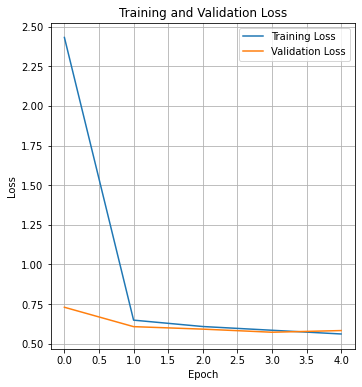

In [27]:
# Plotting training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

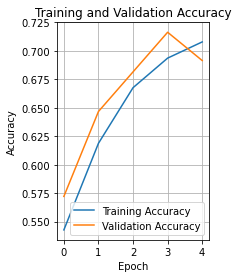

In [28]:

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Evaluate the model on test data
test_loss, test_accuracy, test_f1, test_precision, test_recall = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

In [18]:

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

20/20 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step


In [19]:

# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


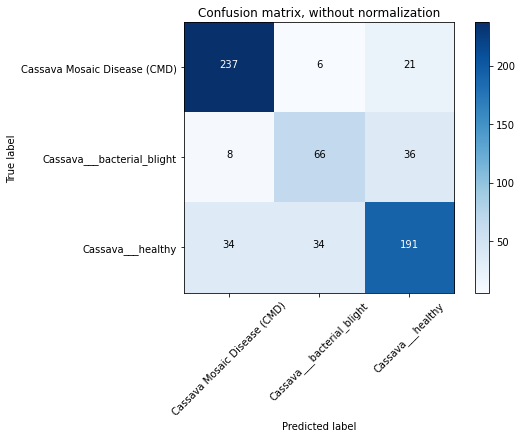

In [21]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, classes=test_generator.class_indices.keys(), title='Confusion matrix, without normalization')


In [22]:
class_names = ['Cassava Mosaic Disease (CMD)', 'Cassava_bacterial_blight', 'Cassava_healthy']
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

                              precision    recall  f1-score   support

Cassava Mosaic Disease (CMD)       0.85      0.90      0.87       264
    Cassava_bacterial_blight       0.62      0.60      0.61       110
             Cassava_healthy       0.77      0.74      0.75       259

                    accuracy                           0.78       633
                   macro avg       0.75      0.75      0.75       633
                weighted avg       0.78      0.78      0.78       633



In [23]:
# Load test dataset with the correct image size
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    image_size=(256, 256),  # Adjust to your model's expected input size
    batch_size=32,
    label_mode='int'  # Adjust according to your labels type
)

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Found 633 files belonging to 3 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step


2024-06-12 09:15:09.786682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


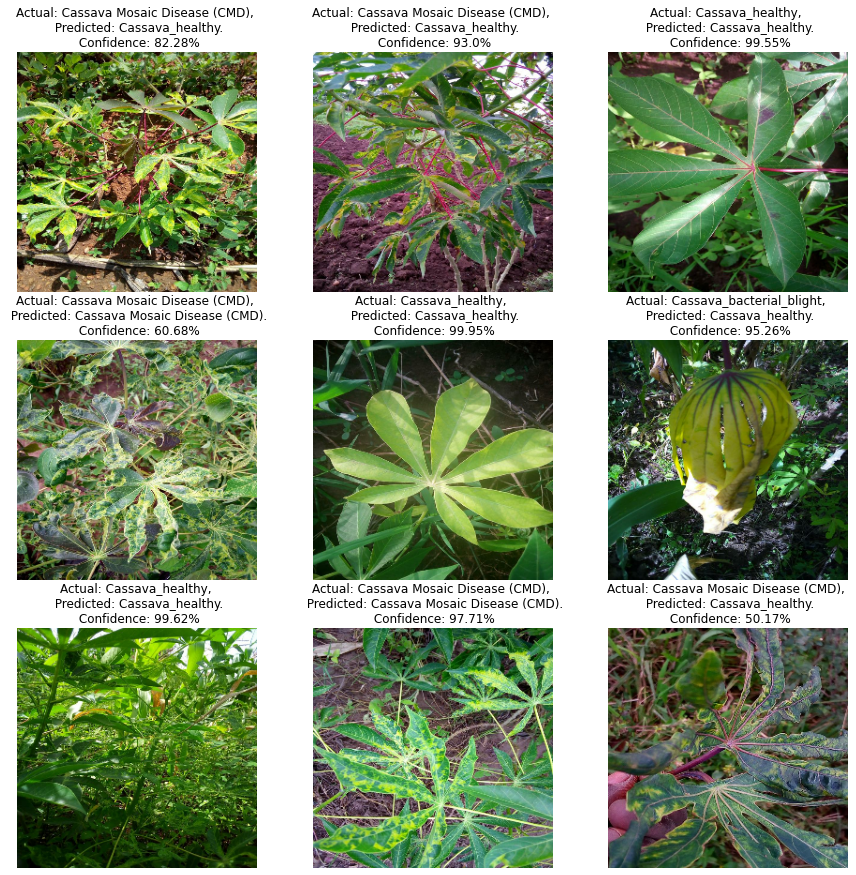

In [24]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis('off')

plt.show()

In [26]:
# Save the model in SavedModel format
saved_model_path = 'saved_model'
tf.saved_model.save(model, saved_model_path)

INFO:tensorflow:Assets written to: saved_model/assets


INFO:tensorflow:Assets written to: saved_model/assets


In [ ]:
# Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

In [ ]:

# Save the TensorFlow Lite model to a file
tflite_model_path = 'CassavaDiseaseModel.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [ ]:
# Save the model in HDF5 format
h5_model_path = 'CassavaDiseaseModel.h5'
model.save(h5_model_path)

FINE TUNING MODEL

In [28]:
img_height = 128 # Set the height of the picture
img_width = 128 # Set the width of the picture

# load model
mobv2_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width,3),
                                              include_top=False, # Transfer learning
                                              weights="imagenet",
                                              )

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mobv2_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobv2_model.layers[:fine_tune_at]:
    layer.trainable = False

# Make sure you have frozen the correct layers
for i, layer in enumerate(mobv2_model.layers):
    if i >= 95:
        print(i, layer.name, layer.trainable)

# Add input layers and output layers
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(mobv2_model.output) # flatten
prediction_layer = tf.keras.layers.Dense(units=4, activation="softmax")(average_pooling_layer)
fineture_model = tf.keras.models.Model(inputs=mobv2_model.input,
                                     outputs=prediction_layer)

# Compile the model
fineture_model.compile(loss="categorical_crossentropy",
                       optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
                       metrics=['accuracy'])

9406464/9406464 [==============================] - 0s 0us/step
Number of layers in the base model:  154
95 block_10_depthwise_relu False
96 block_10_project False
97 block_10_project_BN False
98 block_11_expand False
99 block_11_expand_BN False
100 block_11_expand_relu True
101 block_11_depthwise True
102 block_11_depthwise_BN True
103 block_11_depthwise_relu True
104 block_11_project True
105 block_11_project_BN True
106 block_11_add True
107 block_12_expand True
108 block_12_expand_BN True
109 block_12_expand_relu True
110 block_12_depthwise True
111 block_12_depthwise_BN True
112 block_12_depthwise_relu True
113 block_12_project True
114 block_12_project_BN True
115 block_12_add True
116 block_13_expand True
117 block_13_expand_BN True
118 block_13_expand_relu True
119 block_13_pad True
120 block_13_depthwise True
121 block_13_depthwise_BN True
122 block_13_depthwise_relu True
123 block_13_project True
124 block_13_project_BN True
125 block_14_expand True
126 block_14_expand_BN True

In [29]:

# Define the checkpoint path
checkpoint_path = '/content/drive/MyDrive/CassavaDiseaseModel_finetuned.keras'

checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_acc',  # Use 'val_acc' to monitor validation accuracy
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max',  # 'max' mode since we're monitoring accuracy (higher is better)
    save_freq='epoch'
)

# early = EarlyStopping(
#     monitor='val_acc',  # Use 'val_acc' to monitor validation accuracy
#     min_delta=0,
#     patience=10,
#     verbose=1,
#     mode='auto'
# )

In [ ]:
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[checkpoint]
)

Epoch 1/50
159/159 [==============================] - ETA: 0s - loss: 0.4337 - acc: 0.8236 - f1: 0.8196 - precision: 0.8415 - recall: 0.7996
Epoch 1: val_acc improved from -inf to 0.76461, saving model to /content/drive/MyDrive/CassavaDiseaseModel_finetuned.keras
159/159 [==============================] - 141s 887ms/step - loss: 0.4337 - acc: 0.8236 - f1: 0.8196 - precision: 0.8415 - recall: 0.7996 - val_loss: 0.6220 - val_acc: 0.7646 - val_f1: 0.7580 - val_precision: 0.7680 - val_recall: 0.7485
Epoch 2/50
159/159 [==============================] - ETA: 0s - loss: 0.3986 - acc: 0.8322 - f1: 0.8288 - precision: 0.8437 - recall: 0.8149
Epoch 2: val_acc improved from 0.76461 to 0.78673, saving model to /content/drive/MyDrive/CassavaDiseaseModel_finetuned.keras
159/159 [==============================] - 132s 830ms/step - loss: 0.3986 - acc: 0.8322 - f1: 0.8288 - precision: 0.8437 - recall: 0.8149 - val_loss: 0.6356 - val_acc: 0.7867 - val_f1: 0.7794 - val_precision: 0.7886 - val_recall: 0.

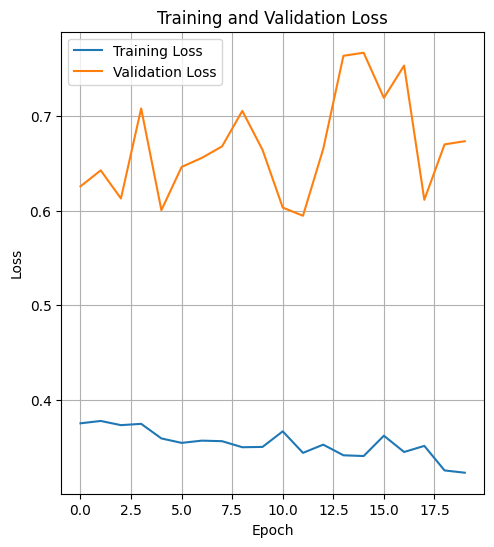

In [ ]:
# Plotting training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

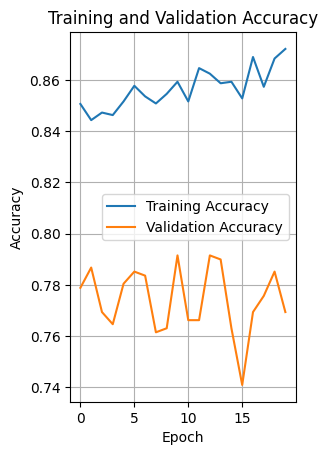

In [ ]:

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:

# Evaluate the model on test data
test_loss, test_accuracy, test_f1, test_precision, test_recall = model.evaluate(test_generator)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test F1 Score:", test_f1)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

20/20 [==============================] - 14s 716ms/step - loss: 0.5337 - acc: 0.7896 - f1: 0.7921 - precision: 0.8016 - recall: 0.7831
Test Loss: 0.5337006449699402
Test Accuracy: 0.7896389365196228
Test F1 Score: 0.7920882105827332
Test Precision: 0.8016006350517273
Test Recall: 0.7830818891525269


In [ ]:

# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

20/20 [==============================] - 14s 722ms/step


In [ ]:

# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization


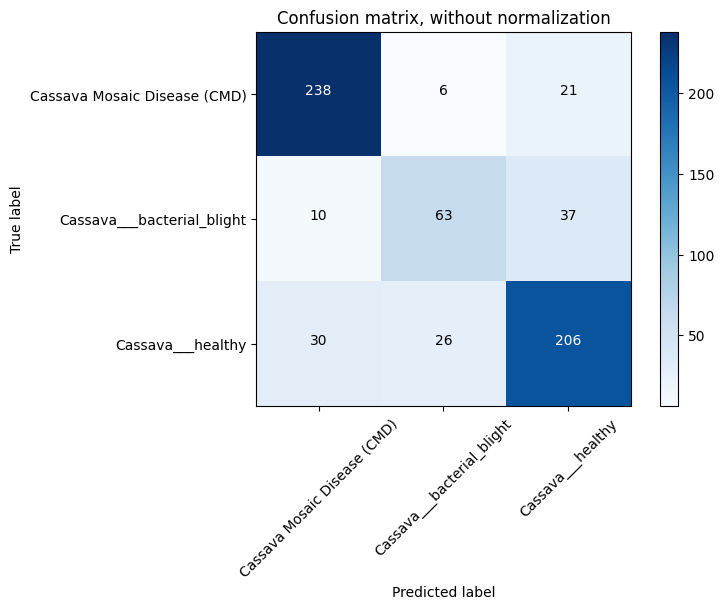

In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, classes=test_generator.class_indices.keys(), title='Confusion matrix, without normalization')


In [ ]:
class_names = ['Cassava Mosaic Disease (CMD)', 'Cassava_bacterial_blight', 'Cassava_healthy']
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

                              precision    recall  f1-score   support

Cassava Mosaic Disease (CMD)       0.86      0.90      0.88       265
    Cassava_bacterial_blight       0.66      0.57      0.61       110
             Cassava_healthy       0.78      0.79      0.78       262

                    accuracy                           0.80       637
                   macro avg       0.77      0.75      0.76       637
                weighted avg       0.79      0.80      0.79       637



In [ ]:
# Load test dataset with the correct image size
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    image_size=(256, 256),  # Adjust to your model's expected input size
    batch_size=32,
    label_mode='int'  # Adjust according to your labels type
)

def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Found 637 files belonging to 3 classes.


In [ ]:
plt.figure(figsize=(15, 15))

for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis('off')

plt.show()

Output hidden; open in https://colab.research.google.com to view.

SAVING MODEL

In [ ]:
# Save the model in SavedModel format
saved_model_path = '/content/drive/MyDrive/saved_model'
tf.saved_model.save(model, saved_model_path)

In [ ]:
# Convert the SavedModel to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
tflite_model = converter.convert()

In [ ]:
# Save the TensorFlow Lite model to a file
tflite_model_path = '/content/drive/MyDrive/CassavaDiseaseModel1.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

In [ ]:
# Save the model in HDF5 format
h5_model_path = '/content/drive/MyDrive/CassavaDiseaseModel1.h5'
model.save(h5_model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
